# Artical: Color demosaicing by estimating luminance and opponent chromatic signals in the Fourier domain

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from skimage.metrics import structural_similarity as ssim
import os

### Read image

In [2]:
image_Path = r'D:\py\Digital_Image_Processing\Image\19.png'
I = cv2.imread(image_Path, cv2.IMREAD_COLOR_RGB)

h, w, t = I.shape

## 1. Traditional Algotithm

### Mosaic Image   

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

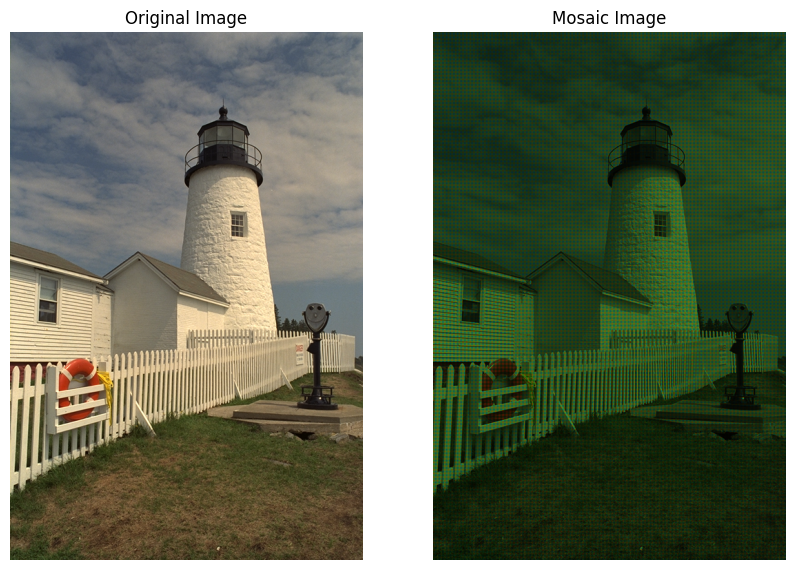

In [3]:
r, g, b = cv2.split(I)

r[1::2, :] = 0
r[:, 1::2] = 0

g[::2, ::2] = 0
g[1::2, 1::2] = 0

b[::2, :] = 0
b[:, ::2] = 0

mosaic_image = cv2.merge([r, g, b])

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(I)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mosaic_image)
plt.title('Mosaic Image')
plt.axis('off')

### Bilinear Interpolation

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

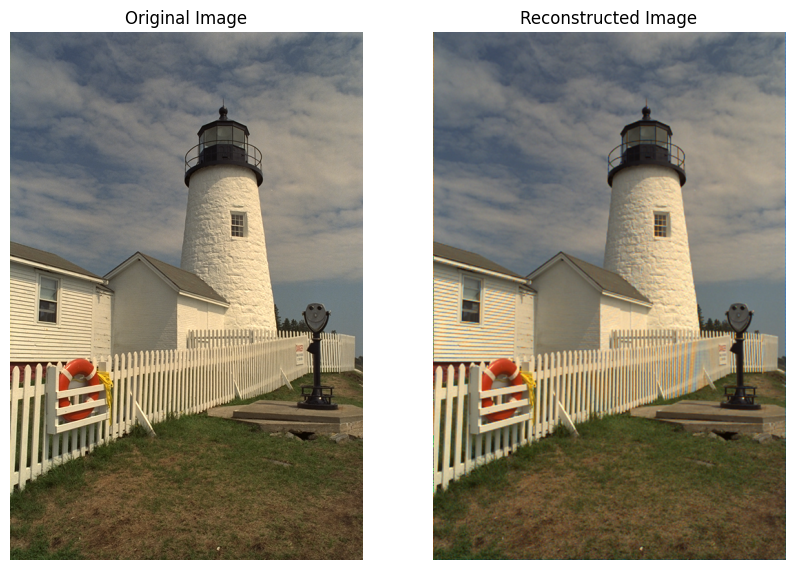

In [4]:
F_rb = np.array([[1, 2, 1],
                 [2, 4, 2],
                 [1, 2, 1]]) / 4

F_g = np.array([[0, 1, 0],
                [1, 4, 1],
                [0, 1, 0]]) / 4

r_re = convolve2d(r, F_rb, 'same', 'symm')
g_re = convolve2d(g, F_g, 'same', 'symm')
b_re = convolve2d(b, F_rb, 'same', 'symm')

r_re = r_re.astype(np.uint8)
g_re = g_re.astype(np.uint8)
b_re = b_re.astype(np.uint8)

reconstructed_image = cv2.merge([r_re, g_re, b_re])

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(I)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.axis('off')

#### Compare original & reconstructed image

In [5]:
def compute_mse (image1, image2):
    mse = np.mean((image1.astype(np.float64) - image2.astype(np.float64)) ** 2)
    return mse

def compute_pnsr (image1, image2):
    mse = compute_mse (image1, image2)
    if mse == 0:
        pnsr = 'inf'
    
    pnsr = 10 * np.log10((255 ** 2) /mse)
    return pnsr

def ssim_rgb(img1, img2):
    ssim_r = ssim(img1[:,:,0], img2[:,:,0], data_range=255)  # Red channel
    ssim_g = ssim(img1[:,:,1], img2[:,:,1], data_range=255)  # Green channel
    ssim_b = ssim(img1[:,:,2], img2[:,:,2], data_range=255)  # Blue channel
    return (ssim_r + ssim_g + ssim_b) / 3

In [6]:
mse_value = compute_mse(I, reconstructed_image)
pnsr_value = compute_pnsr(I, reconstructed_image)
ssim_value = ssim_rgb(I, reconstructed_image)

print(f'MSE: {mse_value}')
print(f'PNSR: {pnsr_value} dB')
print(f"SSIM (RGB): {ssim_value:.4f}")

MSE: 118.93721686469183
PNSR: 27.377625890928172 dB
SSIM (RGB): 0.8746


## 2. New algorithm for Demosaicing - Alleyssons

### Create the multiplexed image

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

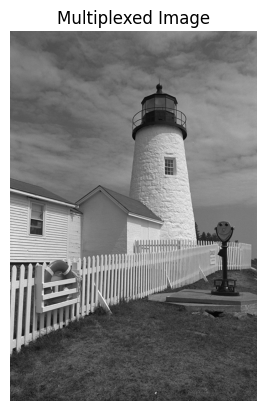

In [7]:
r_2, g_2, b_2 = cv2.split(I)

multiplexed_image = np.zeros((h, w), dtype=np.float64)

multiplexed_image[::2, ::2] = r_2[::2, ::2]  # Red
multiplexed_image[::2, 1::2] = g_2[::2, 1::2]  # Green
multiplexed_image[1::2, ::2] = g_2[1::2, ::2]  # Green
multiplexed_image[1::2, 1::2] = b_2[1::2, 1::2]  # Blue

multiplexed_image = multiplexed_image.astype(np.float64)

plt.imshow(multiplexed_image, cmap='gray')
plt.title('Multiplexed Image')
plt.axis('off')

### First step: Estimating the luminance signal from multiplexed image

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

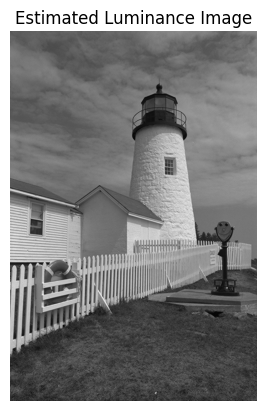

In [8]:
FL = np.array ([[-2, 3, -6, 3, -2],
                [ 3, 4, 2, 4, 3],
                [-6, 2, 48, 2, -6],
                [3, 4, 2, 4, 3],
                [-2, 3, -6, 3, -2]]) / 64

estimate_luminace = convolve2d(multiplexed_image, FL, mode='same', boundary='symm') # anh 2D la anh xam

estimate_luminace = estimate_luminace.astype(np.float64)

plt.imshow(estimate_luminace, cmap='gray')
plt.title('Estimated Luminance Image')
plt.axis('off')

### Second step: Estimating chrominance by high-pass filter

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

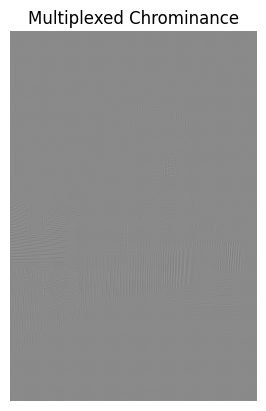

In [9]:
multiplexed_chrominance = multiplexed_image - estimate_luminace

multiplexed_chrominance = multiplexed_chrominance.astype(np.float64)

plt.imshow(multiplexed_chrominance, cmap='gray')
plt.title('Multiplexed Chrominance')
plt.axis('off')

### Third step: De-multiplexing the chrominance

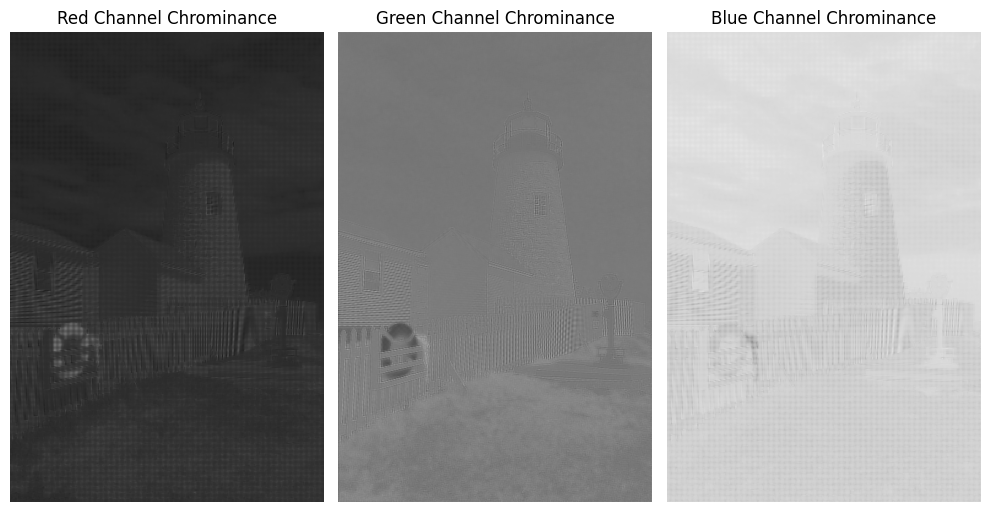

In [10]:
mR = np.zeros((h,w))
mG = np.zeros((h,w))
mB = np.zeros((h,w))

mR[::2, ::2] = 1
mG[::2, 1::2] = 1
mG[1::2, ::2] = 1
mB[1::2, 1::2] = 1

sub_chro_red = multiplexed_chrominance*mR
sub_chro_green = multiplexed_chrominance*mG
sub_chro_blue = multiplexed_chrominance*mB

sub_chro_red = sub_chro_red.astype(np.float64)
sub_chro_green = sub_chro_green.astype(np.float64)
sub_chro_blue = sub_chro_blue.astype(np.float64)

plt.figure(figsize=(10, 12))

plt.subplot(1, 3, 1)
plt.imshow(sub_chro_red, cmap='gray')
plt.title('Red Channel Chrominance')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sub_chro_green, cmap='gray')
plt.title('Green Channel Chrominance')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sub_chro_blue, cmap='gray')
plt.title('Blue Channel Chrominance')
plt.axis('off')

plt.tight_layout()


### Fourth step: interpolating the opponent chromatic signals

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

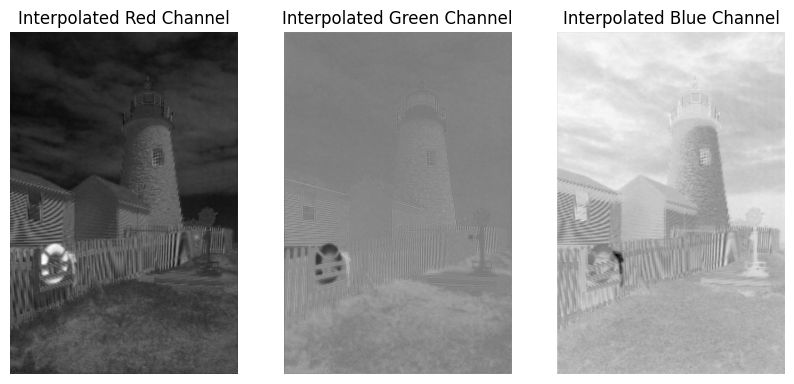

In [11]:
F_rb_2 = np.array([[1, 2, 1],
                 [2, 4, 2],
                 [1, 2, 1]]) / 4

F_g_2 = np.array([[0, 1, 0],
                [1, 4, 1],
                [0, 1, 0]]) / 4

interporlated_red = convolve2d(sub_chro_red, F_rb_2, mode='same', boundary='symm')
interporlated_green = convolve2d(sub_chro_green, F_g_2, mode='same', boundary='symm')
interporlated_blue = convolve2d(sub_chro_blue, F_rb_2, mode='same', boundary='symm')

interporlated_red = interporlated_red.astype(np.float64)
interporlated_green = interporlated_green.astype(np.float64)
interporlated_blue = interporlated_blue.astype(np.float64)

plt.figure(figsize=(10, 12))

plt.subplot(1, 3, 1)
plt.imshow(interporlated_red, cmap='gray')
plt.title('Interpolated Red Channel')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(interporlated_green, cmap='gray')
plt.title('Interpolated Green Channel')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(interporlated_blue, cmap='gray')
plt.title('Interpolated Blue Channel')
plt.axis('off')

### Fifth step: reconstructing the original image from the luminance and interpolated opponent chromatic signals

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

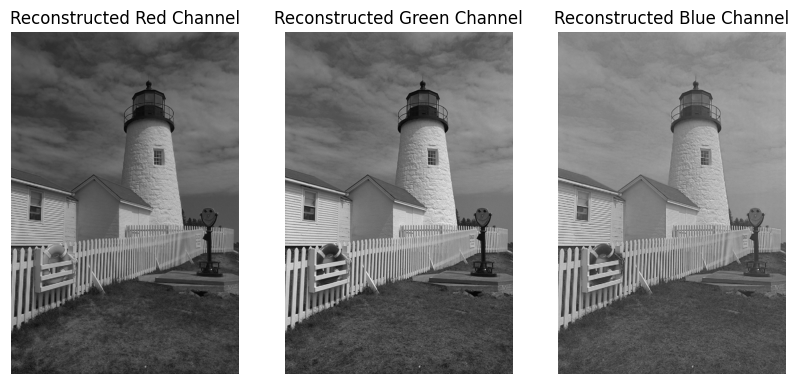

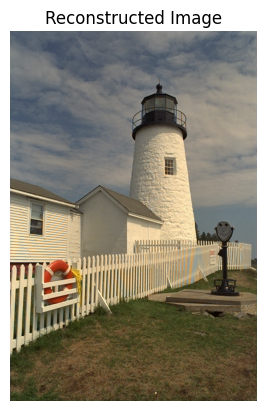

In [12]:
reconstructed_image_2 = np.zeros_like(I)

reconstructed_red = interporlated_red + estimate_luminace
reconstructed_green = interporlated_green + estimate_luminace
reconstructed_blue = interporlated_blue + estimate_luminace

reconstructed_image_2[:, :, 0] = np.clip(reconstructed_red, 0, 255)
reconstructed_image_2[:, :, 1] = np.clip(reconstructed_green, 0, 255)
reconstructed_image_2[:, :, 2] = np.clip(reconstructed_blue, 0, 255)

reconstructed_image_2 = reconstructed_image_2.astype(np.uint8)



plt.figure(figsize=(10, 12))
plt.subplot(1, 3, 1)
plt.imshow(reconstructed_red, cmap='gray')
plt.title('Reconstructed Red Channel')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_green, cmap='gray')
plt.title('Reconstructed Green Channel')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_blue, cmap='gray')
plt.title('Reconstructed Blue Channel')
plt.axis('off')

plt.figure()
plt.imshow(reconstructed_image_2)
plt.title('Reconstructed Image')
plt.axis('off')

### Compare Reconstructed Image with Original Image

In [13]:
mse_value_2 = compute_mse(I, reconstructed_image_2)
pnsr_value_2 = compute_pnsr(I, reconstructed_image_2)
ssim_value_2 = ssim_rgb(I, reconstructed_image_2)

print(f'MSE: {mse_value_2}')
print(f'PNSR: {pnsr_value_2} dB')
print(f'SSIM (RGB): {ssim_value_2:.4f}')

MSE: 25.484696282280815
PNSR: 34.06800898682461 dB
SSIM (RGB): 0.9715


## 3. "Edge-directed" method 

   ### Create Mosaic Image

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

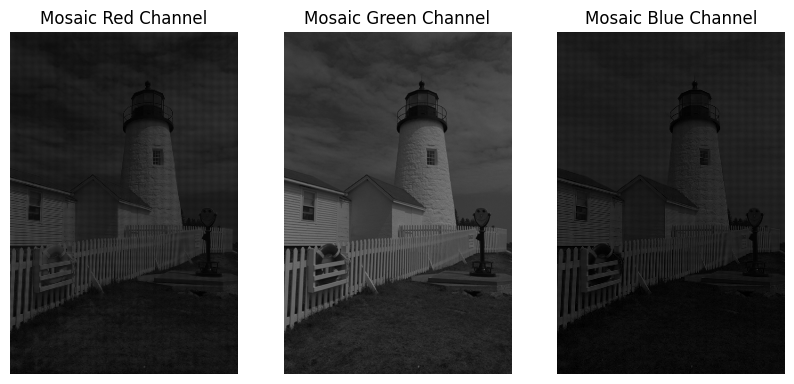

In [14]:
r_3, g_3, b_3 = cv2.split(I)

r_3[1::2, :] = 0
r_3[:, 1::2] = 0

g_3[::2, 1::2] = 0
g_3[1::2, ::2] = 0

b_3[::2, :] = 0
b_3[:, ::2] = 0


plt.figure(figsize=(10, 12))
plt.subplot(1, 3, 1)
plt.imshow(r_3, cmap='gray')
plt.title('Mosaic Red Channel')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(g_3, cmap='gray')
plt.title('Mosaic Green Channel')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(b_3, cmap='gray')
plt.title('Mosaic Blue Channel')
plt.axis('off')


### First step: Reconstruct Green Channel

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

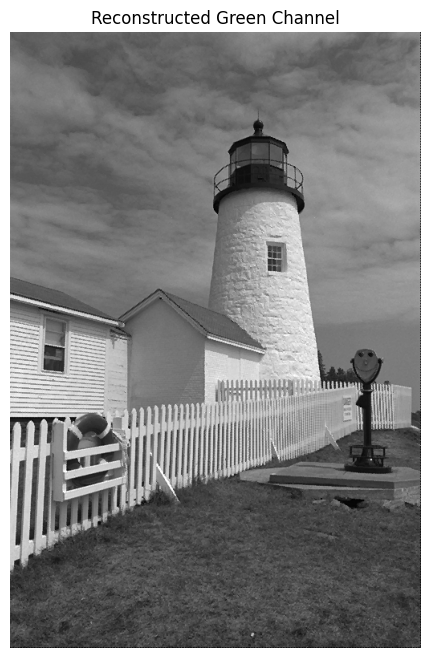

In [15]:
h_g_3, w_g_3 = g_3.shape

e = 0

# Create a new array with a border of zeros
g_3_padded = np.zeros((h_g_3 + 2, w_g_3 + 2), dtype=np.float64)

# Copy original g_3 into the center of g_3_padded
g_3_padded[1:-1, 1:-1] = g_3

for i in range(1, h_g_3, 2):
    for j in range(2, w_g_3, 2):
        G1, G2, G3, G4 = g_3_padded[i-1, j], g_3_padded[i, j-1], g_3_padded[i+1, j], g_3_padded[i, j+1]
        delta_H = abs(G2 - G3)
        delta_V = abs(G1 - G4)
        if delta_H + e < delta_V:
            g_3_padded[i, j] = (G2 + G3) / 2
        elif delta_V + e < delta_H:
            g_3_padded[i, j] = (G1 + G4) / 2
        else:
            g_3_padded[i, j] = (G1 + G2 + G3 + G4) / 4

for i in range(2, h_g_3, 2):
    for j in range(1, w_g_3, 2):
        G1, G2, G3, G4 = g_3_padded[i-1, j], g_3_padded[i, j-1], g_3_padded[i+1, j], g_3_padded[i, j+1]
        delta_H = abs(G2 - G3)
        delta_V = abs(G1 - G4)
        if delta_H + e < delta_V:
            g_3_padded[i, j] = (G2 + G3) / 2
        elif delta_V + e < delta_H:
            g_3_padded[i, j] = (G1 + G4) / 2
        else:
            g_3_padded[i, j] = (G1 + G2 + G3 + G4) / 4

g_3 = g_3_padded[1:-1, 1:-1]

reconstructed_green_3 = g_3.astype(np.float64)

plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_green_3, cmap='gray')
plt.title('Reconstructed Green Channel')
plt.axis('off')

### Second step: Reconstruct Red channel

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

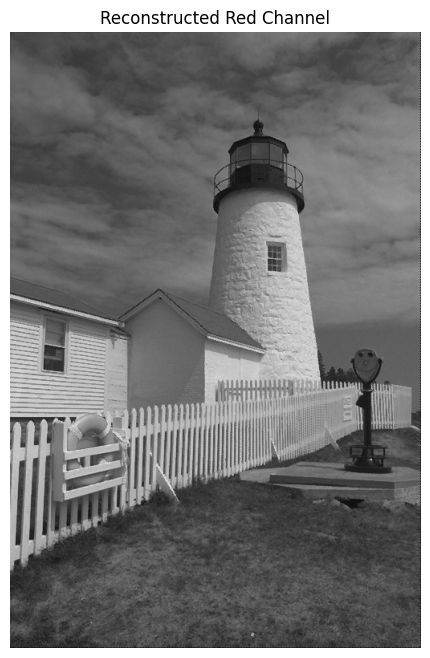

In [16]:
F_rb_3 = np.array([[1, 2, 1],
                 [2, 4, 2],
                 [1, 2, 1]]) / 4

r_d = r_3 - reconstructed_green_3

r_d1 = r_d * mR

r_d2 = convolve2d(r_d1, F_rb_3, 'same', 'symm')

reconstructed_red_3 = (r_d2 + reconstructed_green_3).astype(np.float64)

plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_red_3, cmap='gray')
plt.title('Reconstructed Red Channel')
plt.axis('off')

### Third step: Reconstruct Blue channel

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

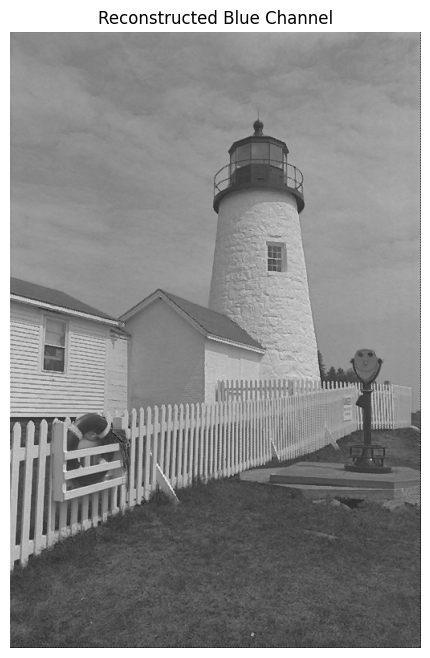

In [17]:
b_d = b_3 - reconstructed_green_3

b_d1 = b_d * mB

b_d2 = convolve2d(b_d1, F_rb_3, 'same', 'symm')

reconstructed_blue_3 = (b_d2 + g_3).astype(np.float64)

plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_blue_3, cmap='gray')
plt.title('Reconstructed Blue Channel')
plt.axis('off')

### Reconstruct Image

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

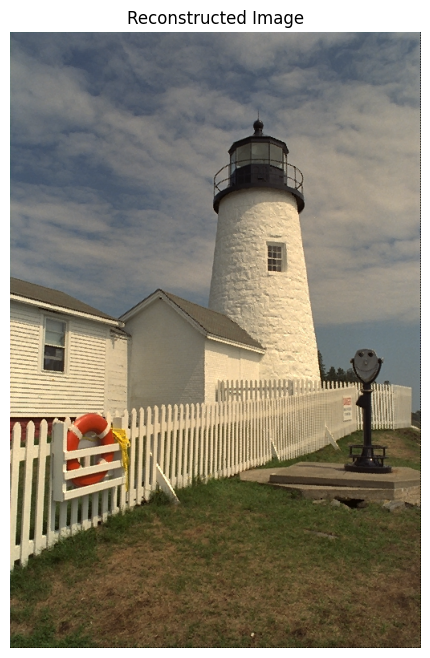

In [18]:
reconstructed_image_3 = np.zeros_like(I, dtype = np.float64)

reconstructed_image_3[:, :, 0] = reconstructed_red_3
reconstructed_image_3[:, :, 1] = reconstructed_green_3
reconstructed_image_3[:, :, 2] = reconstructed_blue_3

reconstructed_image_3 = np.clip(reconstructed_image_3, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_image_3)
plt.title('Reconstructed Image')
plt.axis('off')


In [19]:
mse_value_3 = compute_mse(I, reconstructed_image_3)
pnsr_value_3 = compute_pnsr(I, reconstructed_image_3)
ssim_value_3 = ssim_rgb(I, reconstructed_image_3)

print(f'MSE: {mse_value_3}')
print(f'PNSR: {pnsr_value_3} dB')
print(f'SSIM (RGB): {ssim_value_3:.4f}')

MSE: 63.24334377712674
PNSR: 30.12065537154157 dB
SSIM (RGB): 0.9193


## 4. Laroche Methods

### Create Mosaic image

(np.float64(-0.5), np.float64(515.5), np.float64(771.5), np.float64(-0.5))

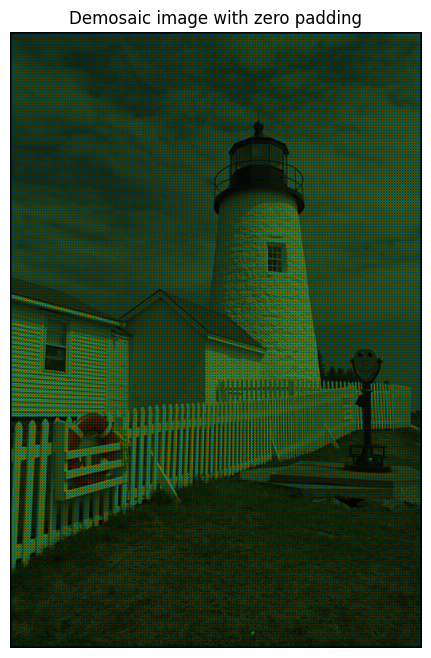

In [20]:
h_4, w_4, c_4 = I.shape

I_padded = np.zeros((h_4 + 4, w_4 + 4, c_4), dtype=np.float64)
I_padded[2:h_4 + 2, 2:w_4 + 2, :] = I

mosaic_image_4 = np.zeros_like(I, dtype = np.float64)

mosaic_image_4[::2, ::2, 0] = I[::2, ::2, 0]
mosaic_image_4[1::2, 1::2, 2] = I[1::2, 1::2, 2]
mosaic_image_4[::2, 1::2, 1] = I[::2, 1::2, 1]
mosaic_image_4[1::2, ::2, 1] = I[1::2, ::2, 1]

I_padded[2:-2, 2:-2, :] = mosaic_image_4

plt.figure(figsize=(10, 8))
plt.imshow(I_padded.astype(np.uint8))
plt.title("Demosaic image with zero padding")
plt.axis("off")

### Green interpolar at pixel R

In [21]:
H, W, _ = I_padded.shape

for i in range(2, H-2, 2):
    for j in range(2, W-2, 2):
        deltaH1 = np.abs((I_padded[i-2, j, 0] + I_padded[i+2, j, 0])/2 - I_padded[i, j, 0])
        deltaV1 = np.abs((I_padded[i, j-2, 0] + I_padded[i, j+2, 0])/2 - I_padded[i, j, 0])
        if deltaH1 < deltaV1:
            I_padded[i, j, 1] = (I_padded[i-1, j, 1] + I_padded[i+1, j, 1]) / 2
        elif deltaH1 > deltaV1:
            I_padded[i, j, 1] = (I_padded[i, j-1, 1] + I_padded[i, j+1, 1]) / 2
        else:
            I_padded[i, j, 1] = (I_padded[i-1, j, 1] + I_padded[i+1, j, 1] + I_padded[i, j-1, 1] + I_padded[i, j+1, 1]) / 4

### Green interpolar at pixel B

In [22]:
for i in range(3, H-2, 2):
    for j in range(3, W-2, 2):
        deltaH2 = np.abs((I_padded[i-2, j, 2] + I_padded[i+2, j, 2])/2 - I_padded[i, j, 2])
        deltaV2 = np.abs((I_padded[i, j-2, 2] + I_padded[i, j+2, 2])/2 - I_padded[i, j, 2])
        if deltaH2 < deltaV2:
            I_padded[i, j, 1] = (I_padded[i-1, j, 1] + I_padded[i+1, j, 1]) / 2
        elif deltaH2 > deltaV2:
            I_padded[i, j, 1] = (I_padded[i, j-1, 1] + I_padded[i, j+1, 1]) / 2
        else:
            I_padded[i, j, 1] = (I_padded[i-1, j, 1] + I_padded[i+1, j, 1] + I_padded[i, j-1, 1] + I_padded[i, j+1, 1]) / 4

### Blue interpolar at pixel R

In [23]:
for i in range(2, H-2, 2):
    for j in range(2, W-2, 2):
        I_padded[i, j, 2] = (I_padded[i-1, j-1, 2] - I_padded[i-1, j-1, 1] +
                            I_padded[i+1, j-1, 2] - I_padded[i+1, j-1, 1] +
                            I_padded[i+1, j+1, 2] - I_padded[i+1, j+1, 1] +
                            I_padded[i-1, j+1, 2] - I_padded[i-1, j+1, 1]) / 4 + I_padded[i, j, 1]

### Red interpolar at pixel B

In [24]:
for i in range(3, H-2, 2):
    for j in range(3, W-2, 2):
        I_padded[i, j, 0] = (I_padded[i-1, j-1, 0] - I_padded[i-1, j-1, 1] +
                            I_padded[i+1, j-1, 0] - I_padded[i+1, j-1, 1] +
                            I_padded[i+1, j+1, 0] - I_padded[i+1, j+1, 1] +
                            I_padded[i-1, j+1, 0] - I_padded[i-1, j+1, 1]) / 4 + I_padded[i, j, 1]

### Red and Blue interpolar at pixel G

In [25]:
for i in range(3, H-2, 2):
    for j in range(2, W-2, 2):
        I_padded[i, j, 0] = (I_padded[i, j-1, 0] - I_padded[i, j-1, 1] +
                            I_padded[i, j+1, 0] - I_padded[i, j+1, 1]) / 2 + I_padded[i, j, 1]
        I_padded[i, j, 2] = (I_padded[i, j-1, 2] - I_padded[i, j-1, 1] +
                            I_padded[i, j+1, 2] - I_padded[i, j+1, 1]) / 2 + I_padded[i, j, 1]

for i in range(2, H-2, 2):
    for j in range(3, W-2, 2):
        I_padded[i, j, 0] = (I_padded[i, j-1, 0] - I_padded[i, j-1, 1] +
                            I_padded[i, j+1, 0] - I_padded[i, j+1, 1]) / 2 + I_padded[i, j, 1]
        I_padded[i, j, 2] = (I_padded[i, j-1, 2] - I_padded[i, j-1, 1] +
                            I_padded[i, j+1, 2] - I_padded[i, j+1, 1]) / 2 + I_padded[i, j, 1]

### Reconstructed image

(np.float64(-0.5), np.float64(511.5), np.float64(767.5), np.float64(-0.5))

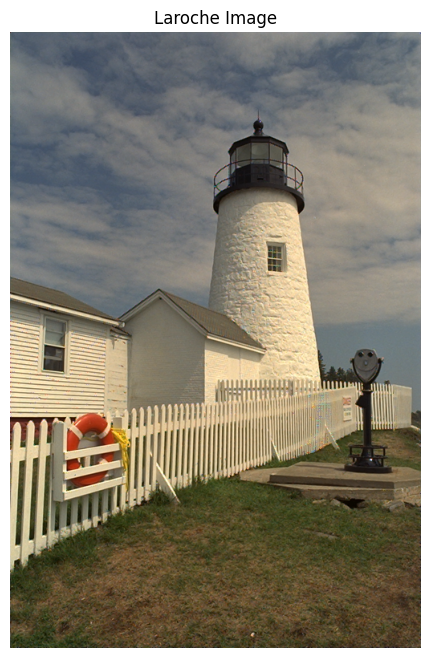

In [26]:
laroche_image = I_padded[2:H-2, 2:W-2, :]
reconstructed_image_4 = np.clip(laroche_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_image_4)
plt.title('Laroche Image')
plt.axis('off')


### Evaluate

In [27]:
mse_value_4 = compute_mse(I, reconstructed_image_4)
pnsr_value_4 = compute_pnsr(I, reconstructed_image_4)
ssim_value_4 = ssim_rgb(I, reconstructed_image_4)

print(f'MSE: {mse_value_4}')
print(f'PNSR: {pnsr_value_4} dB')
print(f'SSIM (RGB): {ssim_value_4:.4f}')

MSE: 21.625741746690537
PNSR: 34.78109348501228 dB
SSIM (RGB): 0.9531
